In [1]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [2]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [3]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [4]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [5]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'hold.54f4e1a7-6eb8-11ec-89d2-f8ac65ab7f15.jpg')

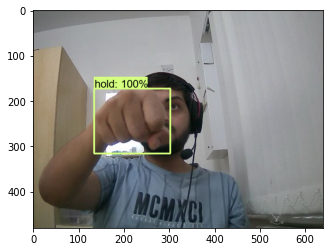

In [6]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)
num_detections = int(detections.pop('num_detections'))



detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.7,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()


In [7]:
detections['detection_scores']



array([0.9972783 , 0.13170289, 0.06979945, 0.05342585, 0.03938306,
       0.0229406 , 0.02293106, 0.02047554, 0.01986468, 0.01876413,
       0.01678437, 0.01644447, 0.01616504, 0.01502368, 0.01450321,
       0.01434705, 0.0142065 , 0.01416712, 0.01399916, 0.01384271,
       0.01365352, 0.01337907, 0.01299204, 0.01272399, 0.01264549,
       0.01251086, 0.0123203 , 0.01231092, 0.01228224, 0.01200896,
       0.0118461 , 0.01183067, 0.01177912, 0.01176153, 0.01134826,
       0.01132574, 0.01132514, 0.01128529, 0.0112196 , 0.011176  ,
       0.01097764, 0.01091763, 0.01074395, 0.01071162, 0.01066676,
       0.01053765, 0.01050084, 0.01042596, 0.00998571, 0.0099272 ,
       0.00989646, 0.00988552, 0.00977075, 0.00962337, 0.00953559,
       0.00919046, 0.00917831, 0.00915267, 0.00902818, 0.00888581,
       0.00882825, 0.00878845, 0.00872936, 0.00865617, 0.00864686,
       0.00863763, 0.00860976, 0.0085844 , 0.00851111, 0.00848913,
       0.00842858, 0.00839959, 0.00838933, 0.00819912, 0.00816

In [8]:
import pyautogui

# Webcam Realtime

In [9]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

prev_pred_label=0
pred_label=0
pred_score=0

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=10,
                min_score_thresh=.2,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (640, 480)))


    
    #doing game part

    if (detections['detection_scores'])[0]>0.80:
        pred_label=(detections['detection_classes']+label_id_offset)[0]
        pred_score=(detections['detection_scores'])[0]
    
    
    if pred_label==1 and pred_score>.80 and prev_pred_label!=pred_label:
        pyautogui.keyUp('down') #Releasing Down Key
        print('UP')
        pyautogui.press('up')

    elif pred_label==2 and pred_score>.80 and prev_pred_label!=pred_label:
        print('DOWN')
        pyautogui.keyDown('down')
        #pyautogui.press('down')

    elif pred_label==3 and pred_score>.80 and prev_pred_label!=pred_label:
        print('HOLD')
        pyautogui.keyUp('down') #Releasing Down Key

    
    if (detections['detection_scores'])[0]>0.80:
        prev_pred_label=pred_label


    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

HOLD
UP
